# Tutorial02_test: Classifier accuracy
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>


## Introduction

In the notebook `tutorial02`, a simple classifier is built to classify the points in the 2D 2-Gaussian dataset. In this notebook we compare the approximate classifier to the exact one. The probability density of the bivariate normal (with $d = 2$) is given by
\begin{align}
\mathcal{N}(x, \mu, \Sigma) & = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2} } \exp\left(-\frac{1}{2} z^T \Sigma^{-1} z \right),
\end{align}
where
\begin{align}
    x & = \begin{bmatrix}
            x_1 \\ x_2
            \end{bmatrix}, \quad
    \mu  = \begin{bmatrix}
            \mu_1 \\ \mu_2
            \end{bmatrix}, \quad
    z  = \begin{bmatrix}
            x_1 - \mu_1 \\ x_2 - \mu_2
            \end{bmatrix},\\
    \Sigma & = \begin{bmatrix}
        \Sigma_{11} & \Sigma_{12}\\
        \Sigma_{21} & \Sigma_{22}
    \end{bmatrix}.
\end{align}
Therefore, the exact classifier is given by
\begin{align}
    p(1|x) & = \frac{\mathcal{N}(x, \mu^{(1)}, \Sigma^{(1)})}{\mathcal{N}(x, \mu^{(1)}, \Sigma^{(1)}) + \mathcal{N}(x, \mu^{(0)}, \Sigma^{(0)})\, / \, \epsilon},
\end{align}
with $\epsilon = \pi(1)\,/\, \pi(0) = 1$ for a **balanced dataset**. The superscripts label the densities of the two classes of points.

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
#%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

import importlib

import mlinphysics.nn as mlp
import mlinphysics.utils.data as dat

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can'r find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(DEVICE):4s}')

params_file = 'gauss2d_params.pth'

Available device: cpu 


## Import exact density

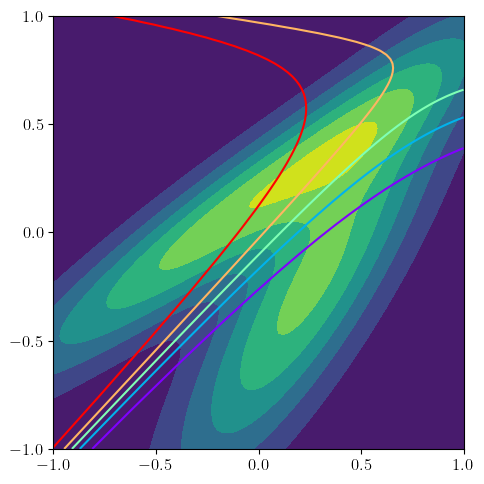

In [3]:
from exactdensity import ExactDensity

fexact = ExactDensity()
fexact.plot()

## Import model

In [4]:
import gauss2d
importlib.reload(gauss2d)

model = gauss2d.model
model.load(params_file)

print(model)
print('number of parameters', mlp.number_of_parameters(model))

Gauss2D(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): SiLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): SiLU()
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): SiLU()
    (6): Linear(in_features=15, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
number of parameters 541


## Compute exact and approximate $p(1|x)$

In [5]:
# exact calculation
x1, x2 = fexact.grid()
pexact = fexact.prob(x1, x2)
print('pexact.shape\t', pexact.shape)

# approximation
# 1. flatten x1 and x2
# 2. stack column-wise 
# 3. convert numpy array to a float32 Tensor
x = np.stack([x1.flatten(), x2.flatten()], axis=1)
x = torch.Tensor(x)
print('x.shape \t', x.shape)

papprox = model(x).reshape(pexact.shape).detach().cpu().numpy()
print('papprox.shape\t', papprox.shape)

pexact.shape	 (101, 101)
x.shape 	 torch.Size([10201, 2])
papprox.shape	 (101, 101)


## Compare exact and approximate $p(1|x)$

Compare contours of constant $p(1|x)$. The solid lines are the results of the exact calculation, while the dashed lines are computed using the ML model.

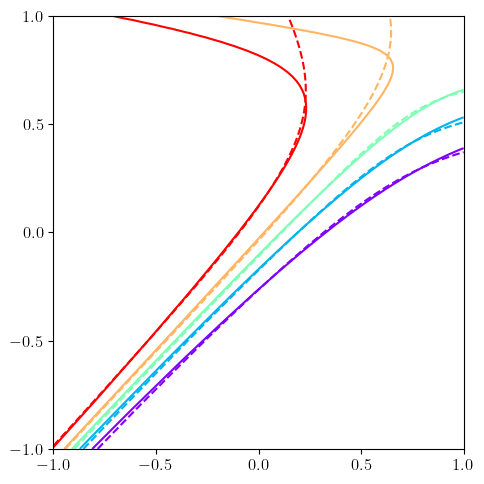

In [6]:
fexact.plot(papprox)